In [30]:
!pip install tensorflow-datasets pandas

     |████████████████████████████████| 9.5 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 32.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [32]:
import tensorflow as tf
import random
import tensorflow_datasets as tfds
import time
from free_propagation_model import FreePropModel
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Data preparation

In [3]:
raw_train_data = tfds.load("mnist", split="train", shuffle_files=True)
raw_test_data = tfds.load("mnist", split="test", shuffle_files=True)

In [4]:
x_train = []
y_train = []

In [5]:
for example in raw_train_data:
    x_train.append(tf.reshape(example["image"], shape=(1, 28*28)))
    y_train.append(tf.reshape(example["label"], shape=(1,)))

In [6]:
x_test = []
y_test = []

In [7]:
for example in raw_test_data:
    x_test.append(tf.reshape(example["image"], shape=(1, 28*28)))
    y_test.append(tf.reshape(example["label"], shape=(1,)))

In [8]:
x_train = tf.reshape(tf.concat(x_train, axis=0), shape=(1000, 60, 28*28)) / 255
y_train = tf.reshape(tf.concat(y_train, axis=0), shape=(1000, 60, 1))

In [9]:
x_test = tf.reshape(tf.concat(x_test, axis=0), shape=(1000, 10, 28*28)) / 255
y_test = tf.reshape(tf.concat(y_test, axis=0), shape=(1000, 10, 1))

# Baseline model training

In [10]:
baseline_train_loss_array = [[] for _ in range(10)]
baseline_train_accuracy_array = [[] for _ in range(10)]
baseline_test_loss_array = [[] for _ in range(10)]
baseline_test_accuracy_array = [[] for _ in range(10)]
baseline_time_array = []

In [11]:
baseline_models = [
    tf.keras.models.Sequential([
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(10),
    ])
    for _ in range(10)
]
for bm in baseline_models:
    bm.build((None, 28*28))

In [12]:
# initial weights of baseline propagation are copied to free propagation
weights_array = []
for bm in baseline_models:
    indices = []
    values = []
    for i in range(bm.trainable_variables[0].shape[0]):
        for j in range(bm.trainable_variables[0].shape[1]):
            indices.append([i, j + 794])
            values.append(bm.trainable_variables[0][i, j])

    for i in range(bm.trainable_variables[2].shape[0]):
        for j in range(bm.trainable_variables[0].shape[1]):
            indices.append([i + 794, j + 784])
            values.append(bm.trainable_variables[0][i, j])

    weights = tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=(844, 844)
    )
    weights = tf.Variable(tf.transpose(tf.sparse.to_dense(weights)))
    weights_array.append(weights)

In [13]:
for i in range(10):
    start_time = time.monotonic()
    print(f"Experiment iteration: {i + 1}")
    baseline_model = baseline_models[i]
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Nadam()

    train_loss = tf.keras.metrics.Mean(name="train_loss")
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
    test_loss = tf.keras.metrics.Mean(name="test_loss")
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")


    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = baseline_model(images, training=True)
            loss = loss_object(labels, predictions)
            gradients = tape.gradient(
                loss,
                [
                    baseline_model.trainable_variables[0],
                    baseline_model.trainable_variables[2],
                ]
            )
        optimizer.apply_gradients(
            zip(
                gradients,
                [
                    baseline_model.trainable_variables[0],
                    baseline_model.trainable_variables[2]
                ]
            )
        )

        train_loss(loss)
        train_accuracy(labels, predictions)


    @tf.function
    def test_step(images, labels):
        predictions = baseline_model(images, training=False)
        t_loss = loss_object(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)


    EPOCHS = 10

    for epoch in range(EPOCHS):
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for images, labels in zip(x_train, y_train):
            train_step(images, labels)

        for test_images, test_labels in zip(x_test, y_test):
            test_step(test_images, test_labels)
            
        baseline_train_loss_array[i].append(train_loss.result().numpy())
        baseline_train_accuracy_array[i].append((train_accuracy.result() * 100).numpy())
        baseline_test_loss_array[i].append(test_loss.result().numpy())
        baseline_test_accuracy_array[i].append((test_accuracy.result() * 100).numpy())

        print(
            f"Epoch {epoch + 1}, "
            f"Loss: {baseline_train_loss_array[i][-1]}, "
            f"Accuracy: {baseline_train_accuracy_array[i][-1]}, "
            f"Test Loss: {baseline_test_loss_array[i][-1]}, "
            f"Test Accuracy: {baseline_test_accuracy_array[i][-1]}"
        )
        
    end_time = time.monotonic()
    baseline_time_array.append(end_time - start_time)

Experiment iteration: 1
Epoch 1, Loss: 0.37564459443092346, Accuracy: 89.59500122070312, Test Loss: 0.20846092700958252, Test Accuracy: 94.12000274658203
Epoch 2, Loss: 0.1853121519088745, Accuracy: 94.70333099365234, Test Loss: 0.15722057223320007, Test Accuracy: 95.41000366210938
Epoch 3, Loss: 0.13895687460899353, Accuracy: 96.10499572753906, Test Loss: 0.13308805227279663, Test Accuracy: 96.19000244140625
Epoch 4, Loss: 0.11204017698764801, Accuracy: 96.86833953857422, Test Loss: 0.12017335742712021, Test Accuracy: 96.43000030517578
Epoch 5, Loss: 0.09436936676502228, Accuracy: 97.37833404541016, Test Loss: 0.11369960010051727, Test Accuracy: 96.51000213623047
Epoch 6, Loss: 0.08170732855796814, Accuracy: 97.69499969482422, Test Loss: 0.10851076245307922, Test Accuracy: 96.69999694824219
Epoch 7, Loss: 0.0717821940779686, Accuracy: 97.97166442871094, Test Loss: 0.10622362792491913, Test Accuracy: 96.76000213623047
Epoch 8, Loss: 0.06342118233442307, Accuracy: 98.23333740234375, Tes

# Free propagation model training

In [14]:
free_prop_train_loss_array = [[] for _ in range(10)]
free_prop_train_accuracy_array = [[] for _ in range(10)]
free_prop_test_loss_array = [[] for _ in range(10)]
free_prop_test_accuracy_array = [[] for _ in range(10)]
free_prop_time_array = []

In [15]:
free_prop_models = [
    FreePropModel(
        28*28,
        10,
        w,
        2,
        tf.identity,
        tf.identity,
        tf.keras.layers.ReLU(),
    ) for w in weights_array
]

In [16]:
for i in range(10):
    start_time = time.monotonic()
    print(f"Experiment iteration: {i + 1}")
    free_prop_model = free_prop_models[i]
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Nadam()

    train_loss = tf.keras.metrics.Mean(name="train_loss")
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
    test_loss = tf.keras.metrics.Mean(name="test_loss")
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")


    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = free_prop_model.fit(images)
            loss = loss_object(labels, predictions)
            gradients = tape.gradient(
                loss,
                [free_prop_model.weights],
            )
        optimizer.apply_gradients(
            zip(
                gradients,
                [free_prop_model.weights],
            )
        )

        train_loss(loss)
        train_accuracy(labels, predictions)


    @tf.function
    def test_step(images, labels):
        predictions = free_prop_model.fit(images)
        t_loss = loss_object(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)


    EPOCHS = 10

    for epoch in range(EPOCHS):
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for images, labels in zip(x_train, y_train):
            train_step(images, labels)

        for test_images, test_labels in zip(x_test, y_test):
            test_step(test_images, test_labels)
            
        free_prop_train_loss_array[i].append(train_loss.result().numpy())
        free_prop_train_accuracy_array[i].append((train_accuracy.result() * 100).numpy())
        free_prop_test_loss_array[i].append(test_loss.result().numpy())
        free_prop_test_accuracy_array[i].append((test_accuracy.result() * 100).numpy())

        print(
            f"Epoch {epoch + 1}, "
            f"Loss: {free_prop_train_loss_array[i][-1]}, "
            f"Accuracy: {free_prop_train_accuracy_array[i][-1]}, "
            f"Test Loss: {free_prop_test_loss_array[i][-1]}, "
            f"Test Accuracy: {free_prop_test_accuracy_array[i][-1]}"
        )
        
    end_time = time.monotonic()
    free_prop_time_array.append(end_time - start_time)

Experiment iteration: 1
Epoch 1, Loss: 0.4271434247493744, Accuracy: 88.57499694824219, Test Loss: 0.23609384894371033, Test Accuracy: 93.33000183105469
Epoch 2, Loss: 0.2084069699048996, Accuracy: 94.06832885742188, Test Loss: 0.17648965120315552, Test Accuracy: 95.04000091552734
Epoch 3, Loss: 0.1571650505065918, Accuracy: 95.51000213623047, Test Loss: 0.14871235191822052, Test Accuracy: 95.74000549316406
Epoch 4, Loss: 0.12714946269989014, Accuracy: 96.38833618164062, Test Loss: 0.13099293410778046, Test Accuracy: 96.2300033569336
Epoch 5, Loss: 0.1063401848077774, Accuracy: 96.98999786376953, Test Loss: 0.11933772265911102, Test Accuracy: 96.55999755859375
Epoch 6, Loss: 0.09137886017560959, Accuracy: 97.36333465576172, Test Loss: 0.11192969232797623, Test Accuracy: 96.79000091552734
Epoch 7, Loss: 0.07962553203105927, Accuracy: 97.71166229248047, Test Loss: 0.10776658356189728, Test Accuracy: 96.86000061035156
Epoch 8, Loss: 0.07054140418767929, Accuracy: 98.00666809082031, Test L

# Experiment results

In [17]:
epochs = [i for i in range(1, 11)]

## Mean time per iteration (in seconds)

Baseline

In [18]:
baseline_time_tensor = tf.constant(baseline_time_array)

In [19]:
tf.reduce_mean(baseline_time_tensor).numpy()

19.199987

In [20]:
tf.math.reduce_std(baseline_time_tensor).numpy()

0.2742702

Free propagation

In [21]:
free_prop_time_tensor = tf.constant(free_prop_time_array)

In [22]:
tf.reduce_mean(free_prop_time_tensor).numpy()

59.70183

In [23]:
tf.math.reduce_std(free_prop_time_tensor).numpy()

3.9195354

## Mean training loss per epoch per experiment iteration

In [24]:
def compare_results(baseline_array, free_prop_array, baseline_label, free_prop_label, y_label, figsize=(9, 9)):
    baseline_tensor = tf.constant(baseline_array)
    mean_baseline_tensor = tf.reduce_mean(baseline_tensor, axis=0)
    std_baseline_tensor = tf.math.reduce_std(baseline_tensor, axis=0)
    
    free_prop_tensor = tf.constant(free_prop_array)
    mean_free_prop_tensor = tf.reduce_mean(free_prop_tensor, axis=0)
    std_free_prop_tensor = tf.math.reduce_std(free_prop_tensor, axis=0)
    
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.plot(epochs, mean_baseline_tensor, label=baseline_label, color="blue")
    ax.plot(epochs, mean_free_prop_tensor, label=free_prop_label, color="black")
    ax.fill_between(epochs, mean_baseline_tensor + std_baseline_tensor, mean_baseline_tensor - std_baseline_tensor, color="blue", alpha=0.25)
    ax.fill_between(epochs, mean_free_prop_tensor + std_free_prop_tensor, mean_free_prop_tensor - std_free_prop_tensor, color="black", alpha=0.2)
    ax.grid()
    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel(y_label)
    

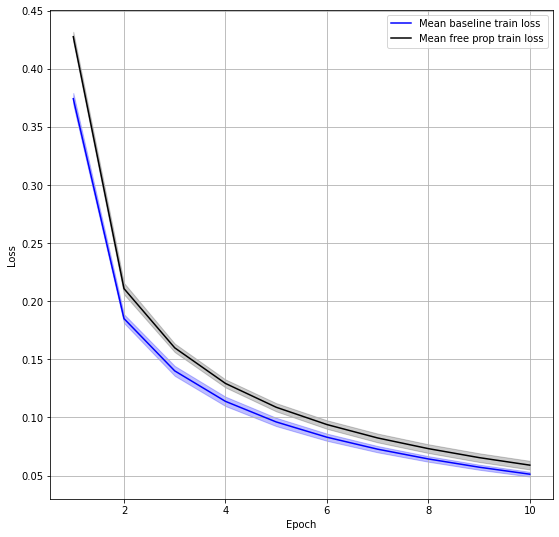

In [25]:
compare_results(
    baseline_train_loss_array,
    free_prop_train_loss_array,
    "Mean baseline train loss",
    "Mean free prop train loss",
    "Loss",
    (9, 9),
)

## Mean training accuracy per epoch per experiment iteration

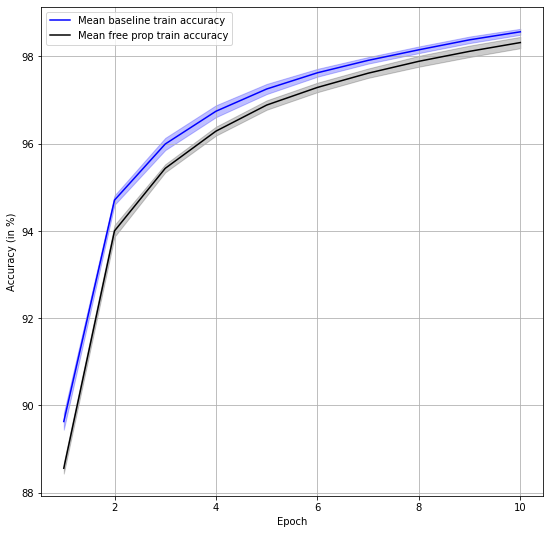

In [26]:
compare_results(
    baseline_train_accuracy_array,
    free_prop_train_accuracy_array,
    "Mean baseline train accuracy",
    "Mean free prop train accuracy",
    "Accuracy (in %)",
    (9, 9),
)

## Mean test loss per epoch per experiment iteration

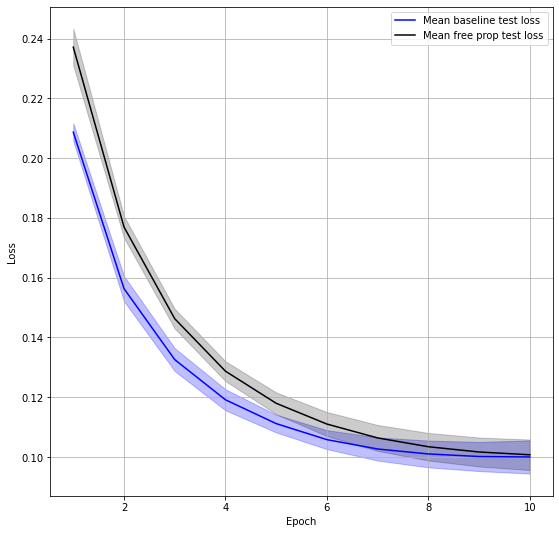

In [27]:
compare_results(
    baseline_test_loss_array,
    free_prop_test_loss_array,
    "Mean baseline test loss",
    "Mean free prop test loss",
    "Loss",
    (9, 9),
)

## Mean test accuracy per epoch per experiment iteration

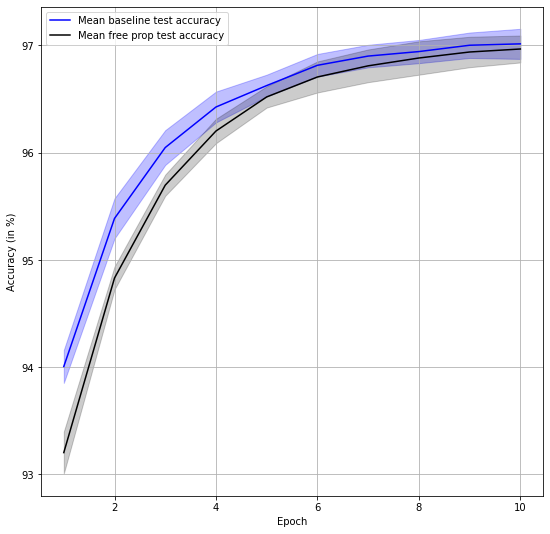

In [28]:
compare_results(
    baseline_test_accuracy_array,
    free_prop_test_accuracy_array,
    "Mean baseline test accuracy",
    "Mean free prop test accuracy",
    "Accuracy (in %)",
    (9, 9),
)

In [34]:
results_folder = Path(".") / "classifying_mnist_results"
results_folder.mkdir(exist_ok=True)

In [38]:
time_df = pd.DataFrame.from_dict({"baseline": baseline_time_array, "free_prop": free_prop_time_array})
time_df.to_csv(results_folder / "time_data.csv", index=False)

In [52]:
def save_results(baseline_source_array, free_prop_source_array, kind):
    result = {"epoch": epochs}
    for index, (baseline_array, free_prop_array) in enumerate(zip(baseline_source_array, free_prop_source_array)):
        attempt = index + 1
        result[f"baseline_{kind}_attempt_{attempt}"] = baseline_array
        result[f"free_prop_{kind}_attempt_{attempt}"] = free_prop_array

    result_df = pd.DataFrame.from_dict(result)
    result_df.to_csv(results_folder/ f"{kind}_data.csv", index=False)

In [53]:
save_results(baseline_train_loss_array, free_prop_train_loss_array, "train_loss")

In [54]:
save_results(baseline_train_accuracy_array, free_prop_train_accuracy_array, "train_accuracy")

In [55]:
save_results(baseline_test_loss_array, free_prop_test_loss_array, "test_loss")

In [56]:
save_results(baseline_test_accuracy_array, free_prop_test_accuracy_array, "test_accuracy")